In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['font.size'] = 24
matplotlib.rcParams['lines.linewidth'] = 5
matplotlib.rcParams['lines.markersize'] = 20

import tensorflow as tf
from tensorflow.python.client import device_lib

import time
import numpy as np
from matplotlib import pyplot
from collections import defaultdict
from ipy_table import make_table, set_row_style, set_column_style
from jupyter_progressbar import ProgressBar

# Devices

lists the devices found by tensorflow

In [2]:
devices = device_lib.list_local_devices()

make_table([["name", "type"]] + [
    [device.name, device.device_type]
    for device in devices
])
set_row_style(0, bold=True)

# Use all devices once such that they are initialized

In [3]:
for device in devices:
    with tf.device(device.name):
        c = tf.constant(5.0)
        x = tf.placeholder(tf.float32)
        product = c * x

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        result = session.run(product, feed_dict={x: 5.0})
        assert result == 25.0, "c * x for x == 5.0 should result in 25.0, but resulted in {} on device {} ({})".format(
            result, device.name, device.device_type)

# Benchmark

In [4]:
results = defaultdict(list)

matrix_sizes = list(map(int, [10, 20, 50, 100, 1000, 5000, 1e4]))

for size in ProgressBar(matrix_sizes):
    for device in devices:
        print('start', device.name, size)
        with tf.device(device.name):
            A = tf.random_uniform(shape=(size, size), minval=0, maxval=1, dtype=tf.float32)
            B = tf.random_uniform(shape=(size, size), minval=0, maxval=1, dtype=tf.float32)
            product = tf.matmul(A, B)
    
        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
            t0 = time.time()
            result = session.run(product)
            t1 = time.time()
            results[device.name].append(t1 - t0)

start /device:CPU:0 10
start /device:GPU:0 10
start /device:CPU:0 20
start /device:GPU:0 20
start /device:CPU:0 50
start /device:GPU:0 50
start /device:CPU:0 100
start /device:GPU:0 100
start /device:CPU:0 1000
start /device:GPU:0 1000
start /device:CPU:0 5000
start /device:GPU:0 5000
start /device:CPU:0 10000
start /device:GPU:0 10000


# Results

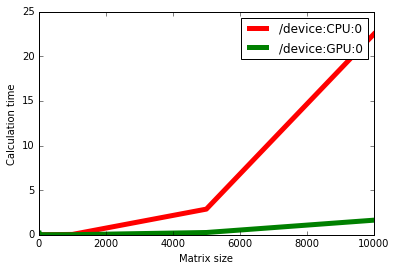

In [5]:
colors = 'rgbcmyk'
marks = ['-', '--', '..']

styles = (color+mark for mark in marks for color in colors)

for style, (name, times) in zip(styles, results.items()):
    pyplot.plot(matrix_sizes, times, style, label=name)

pyplot.legend()

pyplot.ylabel('Calculation time')
pyplot.xlabel('Matrix size')

In [6]:
devices = device_lib.list_local_devices()


make_table([["matrix size"] + ["time (s) on <b>{}</b>".format(device.name) for device in devices]] + [
    [size] + [results[device.name][size_index] for device in devices]
    for size_index, size in enumerate(matrix_sizes)
])
set_column_style(0, bold=True, align='right')